<a href="https://colab.research.google.com/github/changsin/DL/blob/main/notebooks/deidentify_faces_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Anonymize Faces in Python

# 1. Object Detect Faces Using OpenCV
To anonymize faces, the first step is to detect faces. OpenCV library has a pretrained Deep Neural Network specifically for this purpose.

The code is modified from a couple of tutorials using the OpenCV library:
- [Face detection with OpenCV and deep learning](https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/)

- [Face Detection – OpenCV, Dlib and Deep Learning ( C++ / Python )](https://learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/)

Let's use DNN's Face Detector because it is reported to be most accurate.

Let's load images first.

In [1]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [4]:
def load_image(filename):
  image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
  image = imutils.resize(image, width=400)
  return image

OpenCV contains a Deep Learning Neural Network that is pretrained for object detect faces using publicly available datasetts. It uses [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/) and you need to download two files:

1. deploy.prototxt: the network definition file.
2. res10_300x300_ssd_iter_140000.caffemodel: the pretrained network weights file.

In [5]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2021-07-23 06:50:05--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2021-07-23 06:50:06 (11.2 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2021-07-23 06:50:06--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

## Load the Face Detection Model
After the files are downloaded, load them up using cv2.dnn.readNetFromCaffe()

In [6]:
print("Loading the model and the weights")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
dnn = cv2.dnn.readNetFromCaffe(prototxt, model)

Loading the model and the weights


Use the [dnn.blobFromImage](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/) function to construct an input blob by resizing the image to a fixed 300x300 pixels and then normalizing it.


In [120]:
def predict_face_detections(dnn, image,  confidence_threshold=0.5):
  # # resize it to have a maximum width of 400 pixels
  # image = imutils.resize(image, width=400)
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

  print("[INFO] computing object detections...")
  dnn.setInput(blob)
  predictions = dnn.forward()

  h, w = image.shape[:2]
  detections = []
  for i in range(predictions.shape[2]):
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = predictions[0, 0, i, 2]

    # filter out weak predictions by ensuring the `confidence` is
    # greater than the minimum confidence threshold
    if confidence > confidence_threshold:
      # compute the (x, y)-coordinates of the bounding box for the object
      face_box = predictions[0, 0, i, 3:7] * np.array([w, h, w, h])
      # (startX, startY, endX, endY) = face_box.astype("int")
      detections.append((face_box.astype("int"), confidence))

  return detections

In [123]:
# (0, 255, 255) - yellow
DISPLAY_COLOR = (0, 255, 255)
# DISPLAY_COLOR = (255, 0, 0)

THICKNESS = 2

def plot_image_with_labels(image, detections):
  for detection in detections:
    (startX, startY, endX, endY), confidence = detection
    # draw the bounding box of the face along with the associated probability
    text = "{:.2f}%".format(confidence * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.rectangle(image, (startX, startY), (endX, endY), DISPLAY_COLOR, THICKNESS)
    cv2.putText(image, text, (startX, y),
      cv2.FONT_HERSHEY_SIMPLEX, 0.45, DISPLAY_COLOR, THICKNESS)
    
  cv2_imshow(image)

## Detected Faces

[INFO] computing object detections...


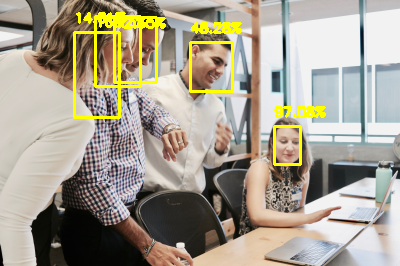

In [124]:
image = load_image("team_faces.jpg")
detections = predict_face_detections(dnn, image, confidence_threshold=0.12)
plot_image_with_labels(image, detections)


## Blur faces in rectangle shapes

In [156]:
def plot_blurred_faces_rect(image, detections, kernel_size=(20, 20)):
  for detection in detections:
    (startX, startY, endX, endY), confidence = detection
    image[startY:endY, startX:endX] = cv2.blur(image[startY:endY, startX:endX], kernel_size)

  cv2_imshow(image)

[INFO] computing object detections...


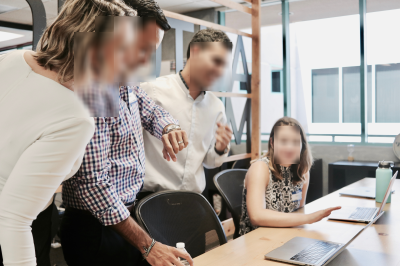

In [158]:
image = load_image("team_faces.jpg")
detections = predict_face_detections(dnn, image, confidence_threshold=0.12)

plot_blurred_faces_rect(image, detections, kernel_size=(7, 7))

## Blur faces in ellipses
OpenCV's blur worked well, but the blurred region is a strict rectangle which does not look nice. How about reshaping it so that it conforms to the contour of a face. Since a face is usually elliptical, let's draw an ellipsis instead a rectangle.
Doing that requires a little bit of work. The basic idea is to create an elliptical mask and flipping the bits. [stackoverflow source](  https://stackoverflow.com/questions/46883245/blur-from-opencv-in-region-of-interest
)

In [146]:
def plot_blurred_faces_elipses(image, detections, kernel_size=(20, 20)):
  """
  How to blur a region of interest in ellipses is taken from:
  https://stackoverflow.com/questions/46883245/blur-from-opencv-in-region-of-interest
  """
  image_blurred = image.copy()

  mask_shape = (image.shape[0], image.shape[1], 1)
  mask = np.full(mask_shape, 0, dtype=np.uint8)

  for detection in detections:
    (startX, startY, endX, endY), confidence = detection
    image_blurred[startY:endY, startX:endX] = cv2.blur(image[startY:endY, startX:endX], kernel_size)

    bh = endY - startY
    bw = endX - startX
    bx = startX
    by = startY

    # create the circle in the mask and in the tempImg, notice the one in the mask is full
    # cv2.circle(tempImg , ( int((bx + bx + bw)/2), int((by + by + bh)/2)), int (bh / 2), (0, 255, 0), 5)
    # cv2.circle(mask , ( int((bx + bx + bw)/2), int((by + by + bh)/2)), int (bh / 2), (255), -1)
    # (image, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness)
    # cv2.ellipse(mask, ((int(bx + bw/2), int(by + bh/2)), (bw, bh), 0), 255, -1)
    cv2.ellipse(mask, ((int(bx + bw/2), int(by + bh/2)), (bw, bh), 0), (255, 0, 0), -1)

  mask_inv = cv2.bitwise_not(mask)
  img1_bg = cv2.bitwise_and(image, image, mask = mask_inv)
  img2_fg = cv2.bitwise_and(image_blurred, image_blurred, mask = mask)
  image = cv2.add(img1_bg,img2_fg)

  cv2_imshow(image)

[INFO] computing object detections...


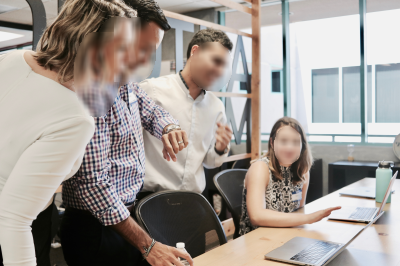

In [155]:
image = load_image("team_faces.jpg")
detections = predict_face_detections(dnn, image, confidence_threshold=0.12)

plot_blurred_faces_elipses(image, detections, kernel_size=(7, 7))

## Pixelate faces
The code for pixelation is borrowed from [Blur and Anonymize Faces with OpenCV and Python](https://www.pyimagesearch.com/2020/04/06/blur-and-anonymize-faces-with-opencv-and-python/)

In [139]:
def plot_pixelated_faces(image, detections, blocks=10):
  for detection in detections:
    (startX, startY, endX, endY), confidence = detection
    image[startY:endY, startX:endX] = pixelate_image(image[startY:endY, startX:endX], blocks)

  cv2_imshow(image)

In [140]:
def pixelate_image(image, blocks=10):
	# divide the input image into NxN blocks
	(h, w) = image.shape[:2]
	xSteps = np.linspace(0, w, blocks + 1, dtype="int")
	ySteps = np.linspace(0, h, blocks + 1, dtype="int")
	# loop over the blocks in both the x and y direction
	for i in range(1, len(ySteps)):
		for j in range(1, len(xSteps)):
			# compute the starting and ending (x, y)-coordinates
			# for the current block
			startX = xSteps[j - 1]
			startY = ySteps[i - 1]
			endX = xSteps[j]
			endY = ySteps[i]
			# extract the ROI using NumPy array slicing, compute the
			# mean of the ROI, and then draw a rectangle with the
			# mean RGB values over the ROI in the original image
			roi = image[startY:endY, startX:endX]
			(B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]
			cv2.rectangle(image, (startX, startY), (endX, endY), (B, G, R), -1)

	# return the pixelated blurred image
	return image

[INFO] computing object detections...


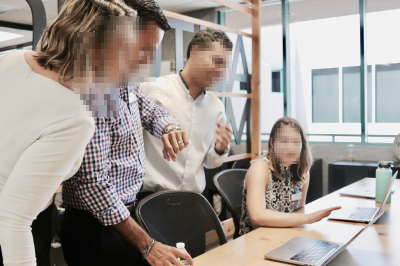

In [145]:
image = load_image("team_faces.jpg")
detections = predict_face_detections(dnn, image, confidence_threshold=0.12)

plot_pixelated_faces(image, detections, blocks=15)